In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
users = pd.read_csv('takehome_users.csv', encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [7]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [9]:
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [10]:
engagement['week-year'] = engagement['time_stamp'].dt.strftime('%U-%Y')

In [11]:
engagement.head()

,time_stamp,user_id,visited,week-year
0,2014-04-22 03:53:30,1,1,16-2014
1,2013-11-15 03:45:04,2,1,45-2013
2,2013-11-29 03:45:04,2,1,47-2013
3,2013-12-09 03:45:04,2,1,49-2013
4,2013-12-25 03:45:04,2,1,51-2013


In [12]:
usage = engagement.groupby(['user_id', 'week-year']).size().reset_index().rename(columns={0:'count'})

In [13]:
usage['adopted'] = usage['count']>=3

In [14]:
adopted_users = list(usage[usage.adopted==True].user_id.unique())

In [15]:
users['adopted'] = users.object_id.apply(lambda x: x in adopted_users).astype(int)

In [16]:
users_clean = users.drop(['name','email'],axis=1)
users_clean = users_clean.set_index('object_id')

In [17]:
users_clean.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
object_id,,,,,,,,
1,2014-04-22 03:53:30,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
3,2013-03-19 23:14:52,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [18]:
users_clean.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [19]:
#One-hot encoding of creation_source. Drop first to avoid multicollinearity
source_dummies = pd.get_dummies(users_clean.creation_source,drop_first=True)
df = pd.concat([users_clean,source_dummies],axis=1)

#drop original column
df = df.drop(['creation_source'],axis=1)

In [20]:
df.creation_time = pd.to_datetime(df.creation_time)
df.last_session_creation_time = pd.to_datetime(df.last_session_creation_time,unit='s')

In [21]:
df['creation_month'] = df.creation_time.dt.month

df['last_session_creation_month'] = df.last_session_creation_time.dt.month

In [22]:
df['invited'] = df.invited_by_user_id.notnull().astype(int)

In [23]:
df = df.drop(['creation_time','last_session_creation_time','invited_by_user_id'],axis=1)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   opted_in_to_mailing_list     12000 non-null  int64  
 1   enabled_for_marketing_drip   12000 non-null  int64  
 2   org_id                       12000 non-null  int64  
 3   adopted                      12000 non-null  int64  
 4   ORG_INVITE                   12000 non-null  uint8  
 5   PERSONAL_PROJECTS            12000 non-null  uint8  
 6   SIGNUP                       12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH           12000 non-null  uint8  
 8   creation_month               12000 non-null  int64  
 9   last_session_creation_month  8823 non-null   float64
 10  invited                      12000 non-null  int64  
dtypes: float64(1), int64(6), uint8(4)
memory usage: 796.9 KB


In [25]:
df['last_session_creation_month'] = df['last_session_creation_month'].fillna(0).astype(int)

11.9 % of observed users were adopted


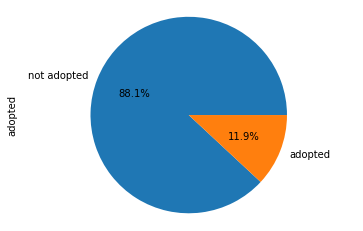

In [26]:
print(format(df.adopted.sum()/df.adopted.count()*100,'1.1f'), '% of observed users were adopted')
_ = df.adopted.value_counts().plot(kind='pie',labels=['not adopted','adopted'],autopct='%1.1f%%')
_ = plt.axis('equal')

In [27]:
X = df.drop(['adopted'],axis=1)
y = df['adopted']

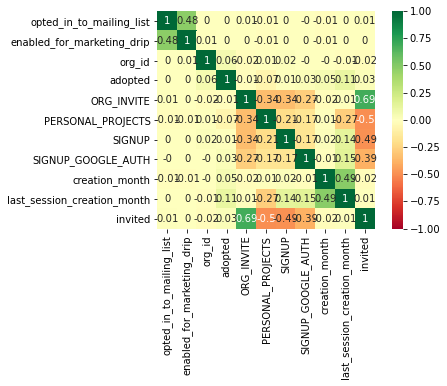

In [28]:
_ = sns.heatmap(df.corr().round(2),square=True,annot=True,cmap='RdYlGn',vmin=-1, vmax=1)

The heatmap shows that last_session_creation_month has the strongest direct, linear correation with adopted (0.22). None of the other columns have a correlation factor greater than 0.7 so no multicollinearity is evident from this matrix. We will not look at the variance inflation factors to confirm.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Multicollinearity analysis
#Get features
feature_x = X
#Convert features to float arrays
feature_x_arr = np.array(feature_x, dtype=float)

#VIF Factor dataframe
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(feature_x_arr, i) for i in range(feature_x_arr.shape[1])]
vif["features"] = feature_x.columns
vif.sort_values(by='VIF',ascending=False).head()

,VIF,features
9,5.706871,invited
5,1.995989,SIGNUP
4,1.934526,PERSONAL_PROJECTS
3,1.915684,ORG_INVITE
6,1.655964,SIGNUP_GOOGLE_AUTH


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# use CV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200]}
model = GridSearchCV(clf, params)
model.fit(X_train, y_train)
print('Best parameters were', model.best_params_)
print('Best average precision was', model.best_score_)

Best parameters were {'n_estimators': 200}
Best average precision was 0.9513095238095239


In [36]:
# evluation of the model
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(
    random_state=42, class_weight='balanced', n_estimators=100
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.9536111111111111
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3170
           1       0.83      0.77      0.80       430

    accuracy                           0.95      3600
   macro avg       0.90      0.87      0.89      3600
weighted avg       0.95      0.95      0.95      3600



In [37]:
imp = pd.Series(model.feature_importances_, index=X.columns)
imp = imp.sort_values(ascending=False)
print(imp)

last_session_creation_month    0.576067
creation_month                 0.199500
org_id                         0.170131
PERSONAL_PROJECTS              0.011470
opted_in_to_mailing_list       0.010213
enabled_for_marketing_drip     0.008360
ORG_INVITE                     0.008178
SIGNUP_GOOGLE_AUTH             0.005620
invited                        0.005544
SIGNUP                         0.004916
dtype: float64


It seems like users who have not logged in within the past 2 years will not be considered adopted users and there are a significant number of users who have not logged in within the last 2 years. We would want to analyze this dataset further to better understand why they have not logged in. Most adopted users last logged in in May and June so I would want to understand what was done in May and June (any special deals etc.) that could have led to better user retention.